In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import link
import network
import path 
import mode
import path2link
import ride_hailing

In [2]:
# read data
my_link = pd.read_excel('../input_network/pilot_net.xlsx', sheet_name='link_info')
my_link['I'] = 0
my_node = pd.read_excel('../input_network/pilot_net.xlsx', sheet_name='node_info')
my_link['name'] = my_link['from'].astype('str') +'-'+ my_link['to'].astype('str')
my_demand = pd.read_excel('../input_network/pilot_net.xlsx', sheet_name='demand_info')
print(my_demand)

  OD_pair  demand
0   r1-s1    1000


In [3]:
# set parameter
origin_zone = ['r1']
destination_zone = ['s1']
theta_1 = 0.05# path
theta_2 = 0.03 # mode
miu_in = 20
miu_out = 15
lamda_0_hailing = 2
lamda_0_PR = 15
lamda_0_transit=3
N_hailing = 500

In [4]:
# 0. generate path set
my_network = network.get_graph(link_table=my_link, node_table=my_node)
my_path_set = path.get_path_set(G=my_network, origin_zone=origin_zone, destination_zone=destination_zone)
my_path_set

,OD_pair,path_id,mode,link_sque,name_sque,attribute_set
0,r1-s1,path-1,auto,"[1, 2, 3, 4]","[r1-N1, N1-N2, N2-N3, N3-s1]","[board_auto, auto, alight_auto]"
1,r1-s1,path-2,P&R,"[1, 2, 5, 8, 9]","[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]"
2,r1-s1,path-3,transit,"[6, 7, 8, 9]","[r1-N4, N4-N5, N5-N6, N6-s1]","[board_transit, transit, alight_transit]"
3,r1-s1,path-4,R&T,"[10, 11, 12, 8, 9]","[r1-N7, N7-N8, N8-N5, N5-N6, N6-s1]","[board_ride-hailing, ride-hailing, R&T, transi..."


In [5]:
# 1. initializing path set
# 1.1 initializing path cost
my_path_set = path.get_path_info(path_set=my_path_set, link_table=my_link)
my_path_set = path.path_cost(path_set=my_path_set,miu_in=miu_in, miu_out=miu_out, lamda_0_transit=lamda_0_transit, theta_1=theta_1)
# initializing path flow
my_path_set['path_flow'] = my_demand['demand'].sum() / len(my_path_set) # average assignment
my_path_set['I'] = 0 # add initial iteration number
my_path_set

,OD_pair,path_id,mode,link_sque,name_sque,attribute_set,path_length,path_travel,path_walk,path_wait,path_congestion,path_penalty,path_fare,path_duration,path_cost,path_exp,path_flow,I
0,r1-s1,path-1,auto,"[1, 2, 3, 4]","[r1-N1, N1-N2, N2-N3, N3-s1]","[board_auto, auto, alight_auto]",14.0,0,0,0,0,0,0,0,-0.00,1.000000,250.0,0
1,r1-s1,path-2,P&R,"[1, 2, 5, 8, 9]","[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,0,5,5,0,12,20,10,-28.50,0.240508,250.0,0
2,r1-s1,path-3,transit,"[6, 7, 8, 9]","[r1-N4, N4-N5, N5-N6, N6-s1]","[board_transit, transit, alight_transit]",15.0,0,10,0,0,0,0,10,-5.50,0.759572,250.0,0
3,r1-s1,path-4,R&T,"[10, 11, 12, 8, 9]","[r1-N7, N7-N8, N8-N5, N5-N6, N6-s1]","[board_ride-hailing, ride-hailing, R&T, transi...",14.0,0,7,0,0,12,0,7,-7.75,0.678752,250.0,0


In [6]:
# 1.2 generate mode set
my_mode_set = mode.get_mode_set(paths=my_path_set,theta_1=theta_1,theta_2=theta_2)
my_mode_set['I'] = 0 # add initial iteration number
my_mode_set

,mode,path_logsum,exp_logsum,mode_logit,I
0,P&R,4.310427,0.129313,0.209897,0
1,R&T,10.361009,0.310830,0.251674,0
2,auto,13.862944,0.415888,0.279553,0
3,transit,11.301413,0.339042,0.258875,0


In [7]:
# 1.3 get demand-based flow
new_paths = mode.get_y_flow(mode_set=my_mode_set, path_set=my_path_set,demand=my_demand)
new_paths['I'] = 0 # add initial iteration number
new_paths['path_flow'] = my_path_set['path_flow']
new_paths

,OD_pair,demand,path_id,name_sque,attribute_set,path_length,path_duration,path_cost,mode,mode_logit,mode_flow,path_logit,y_flow,I,path_flow
0,r1-s1,1000,path-1,"[r1-N1, N1-N2, N2-N3, N3-s1]","[board_auto, auto, alight_auto]",14.0,0,-0.00,auto,0.279553,279.553315,1.0,279.553315,0,250.0
1,r1-s1,1000,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,10,-28.50,P&R,0.209897,209.897124,1.0,209.897124,0,250.0
2,r1-s1,1000,path-3,"[r1-N4, N4-N5, N5-N6, N6-s1]","[board_transit, transit, alight_transit]",15.0,10,-5.50,transit,0.258875,258.875465,1.0,258.875465,0,250.0
3,r1-s1,1000,path-4,"[r1-N7, N7-N8, N8-N5, N5-N6, N6-s1]","[board_ride-hailing, ride-hailing, R&T, transi...",14.0,7,-7.75,R&T,0.251674,251.674096,1.0,251.674096,0,250.0


In [8]:
######################################################################################
# iteration
from sklearn.metrics import mean_squared_error
import numpy as np

maximum_iter = 1000
acceptable_gap = 0.01

# 1. initialize a list to store the result of each iteration
iteration = []
res_link_flow = my_link.copy()
res_path_flow = new_paths.copy()
res_path_set = my_path_set.copy()
res_mode_set = my_mode_set.copy()
idle_ride_hailing = [[0, N_hailing]]

for I in range(1, maximum_iter+1):
    # 2.1 cheak the convergence
    MSE = mean_squared_error(new_paths['path_flow'].values, new_paths['y_flow'].values)
    RMSE = np.sqrt(MSE)
    print('Iteration = {0}, gap = {1},'.format(I,RMSE))

    if RMSE < acceptable_gap:
        break

    # 2.2 update path flow
    new_paths['path_flow'] = new_paths['path_flow'] + (1 / I) * (new_paths['y_flow'] - new_paths['path_flow'])
    path_flow = new_paths['path_flow'].values

    # 2.3 update link flow
    my_link_set = path2link.update_link_flow(path_set=new_paths, link_table=my_link)

    # 2.4 compute idle ride-hailing vehicle number
    n_idle_hailing = ride_hailing.compute_idle_vehile(link_table=my_link,N_hailing=N_hailing)
    print(f'the number of idle_hailing:{n_idle_hailing}')

    # 2.5 update link cost
    my_link_set = link.compute_link_time(link_table=my_link_set,
                    n_idle=n_idle_hailing,
                    lamda_0_auto=link.compute_lamda_0_auto(),
                    lamda_0_hailing=lamda_0_hailing,
                    lamda_0_PR=lamda_0_PR,
                    miu_out=miu_out)
    my_link_set['I'] = I # add iteration number in link_set
    # record wait time

    # 2.6 re-compute path information
    my_path_set = path.get_path_info(path_set=my_path_set, link_table=my_link_set)
    my_path_set = path.path_cost(path_set=my_path_set,miu_in=miu_in, miu_out=miu_out, lamda_0_transit=lamda_0_transit, theta_1=theta_1)
    my_path_set['I'] = I # add initial iteration number

    # 2.8 re-generate mode set
    my_mode_set = mode.get_mode_set(paths=my_path_set, theta_1=theta_1,theta_2=theta_2)
    my_mode_set['I'] = I # add iteration number in mode_set
    #print(my_mode_set['mode_logit'].sum())

    # 2.9 re-generate y_flow
    new_paths = mode.get_y_flow(mode_set=my_mode_set,path_set=my_path_set, demand=my_demand)
    new_paths['path_flow'] = path_flow # Update path flow for the next iteration based on MSA updating method 
    new_paths['I'] = I # add iteration number

    # 2.13 store the result of each iteration
        # 2.13.1 iteration number and gap
    iteration.append([I, RMSE])
        # 2.13.2 link_set
    res_link_flow = pd.concat([res_link_flow, my_link_set], ignore_index=True)
        # 2.13.3 path_set
    res_path_set = pd.concat([res_path_set, my_path_set], ignore_index=True)
    res_path_flow = pd.concat([res_path_flow, new_paths], ignore_index=True)
        # 2.13.4 mode_set
    res_mode_set = pd.concat([res_mode_set, my_mode_set], ignore_index=True)
        # 2.13.5 n_idle
    idle_ride_hailing.append([I, n_idle_hailing])

    # 3. transform the iteration to dataframe
iteration = pd.DataFrame(iteration, columns=['I', 'RMSE'])
idle_ride_hailing = pd.DataFrame(idle_ride_hailing, columns=['I', 'n_idle'])
idle_ride_hailing['wait_time'] = idle_ride_hailing['n_idle'].apply(lambda x: (2 / (1 + x**0.5)) * 60)

Iteration = 1, gap = 25.314104599063764,
the number of idle_hailing:479.02715864590374
Iteration = 2, gap = 13.139700575128943,
the number of idle_hailing:429.2616861126187
Iteration = 3, gap = 6.303594016593199,
the number of idle_hailing:428.67019571403364
Iteration = 4, gap = 4.127096042019364,
the number of idle_hailing:428.9426560065583
Iteration = 5, gap = 3.0609377224310204,
the number of idle_hailing:429.12341366635854
Iteration = 6, gap = 2.4293448165843423,
the number of idle_hailing:429.2446459241885
Iteration = 7, gap = 2.012088016470209,
the number of idle_hailing:429.33145807574607
Iteration = 8, gap = 1.71612275859338,
the number of idle_hailing:429.39671667261194
Iteration = 9, gap = 1.4953990539296957,
the number of idle_hailing:429.4475812011342
Iteration = 10, gap = 1.3245336891421933,
the number of idle_hailing:429.4883520958772
Iteration = 11, gap = 1.1883930680163195,
the number of idle_hailing:429.521769615816
Iteration = 12, gap = 1.0773976459803813,
the number 

In [9]:
# RMSE
RMSE = iteration

# idle ride-hailing vehicle number
ride_hailing = idle_ride_hailing

# market share
mode = res_mode_set

In [10]:
import matplotlib.pyplot as plt
import numpy as np

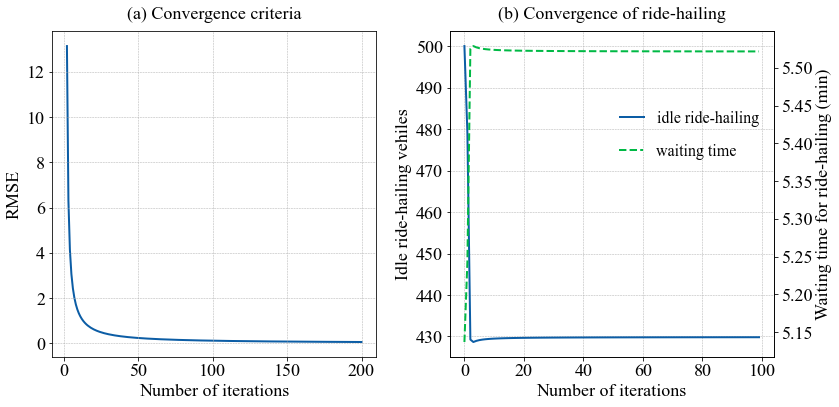

In [11]:
num_loc = 200
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
ax1.grid(ls = '--', lw = 0.5, zorder = 0)
ax1.plot(RMSE['I'].iloc[1:num_loc], RMSE['RMSE'].iloc[1:num_loc], '-', lw = 2, color='#0c5DA5', label='RMSE', markersize=5, zorder =1)
#ax1.set_xticks(np.arange(5, 105, 10))
#ax1.set_xlim(0, 101)
#ax1.set_yticks(np.arange(0, 0.55, 0.05))
#ax1.set_ylim(0, 0.5)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('RMSE')
ax1.set_title('(a) Convergence criteria', fontsize=18, loc = 'center', y=1.02)

ax2 = plt.subplot(1,2,2)
ax2.grid(ls = '--', lw = 0.5)
ax2.plot(ride_hailing['I'].iloc[:100], ride_hailing['n_idle'].iloc[:100], '-', lw = 2, color='#0c5DA5', label='idle ride-hailing', markersize=5)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Idle ride-hailing vehiles')
# ax2.set_xticks(np.arange(5, 31, 5))
# ax2.set_xlim(0.5, 30.5)
# ax2.set_yticks(np.arange(155,210, 5))
# ax2.set_ylim(150,205)
ax2.set_title('(b) Convergence of ride-hailing', fontsize=18, y= 1.02)

ax3 = plt.twinx(ax2)
ax3.plot(ride_hailing['I'].iloc[:100], ride_hailing['wait_time'].iloc[:100], '--', lw = 2, color='#00B945', label='waiting time', markersize=4)
# ax3.set_yticks(np.arange(3.9, 4.7, 0.1))
# ax3.set_ylim(3.8,4.6)
ax3.set_ylabel('Waiting time for ride-hailing (min)')

ax2.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5, bbox_to_anchor=(1, 0.8))
ax3.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5, bbox_to_anchor=(0.93, 0.7))

plt.tight_layout()

plt.show()

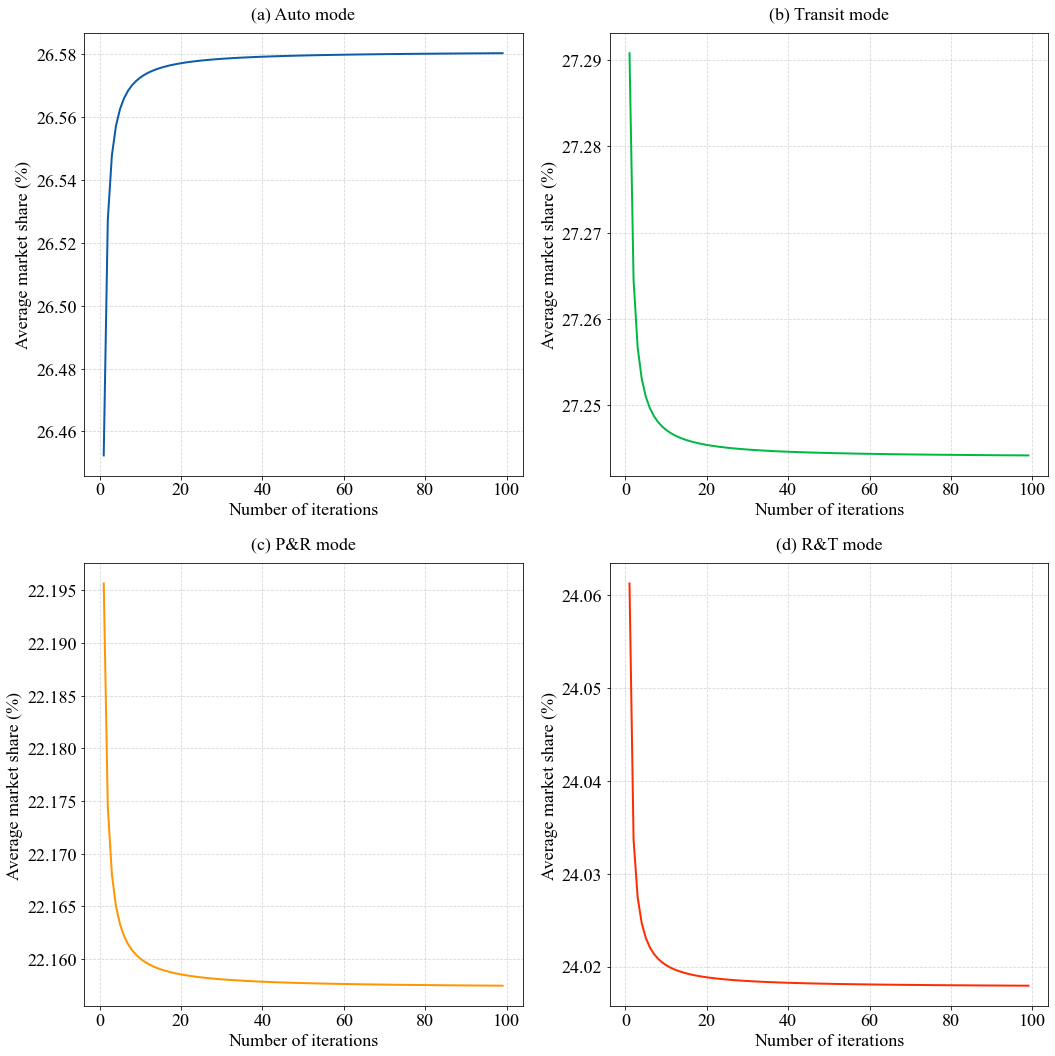

In [12]:
# market share
num_loc = 100
#plt.ticklabel_format(style='plain')

fig,ax = plt.subplots(2,2, figsize=(15,15))
ax = ax.flatten()

ax1 = ax[0]
ax1.ticklabel_format(useOffset=False)
ax1.grid(ls='--', alpha = 0.5)
ax1.plot(mode[mode['mode'] == 'auto'].iloc[1:num_loc]['I'], 
         mode[mode['mode'] == 'auto'].iloc[1:num_loc]['mode_logit']*100, 
         '-', color='#0c5DA5', label='Auto', markersize=5, lw=2)
# ax1.set_xticks(np.arange(0, 205, 20))
# ax1.set_xlim(0.5, 50.5)
# ax1.set_yticks(np.arange(296.8, 298.4, 0.2))
#ax1.set_ylim(36.125,36.127)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Average market share (%)')
ax1.set_title('(a) Auto mode', fontsize=18, loc='center', y=1.02)

ax2 = ax[1]
ax2.ticklabel_format(useOffset=False)
ax2.grid(ls='--', alpha = 0.5)
ax2.plot(mode[mode['mode'] == 'transit'].iloc[1:num_loc]['I'], 
         mode[mode['mode'] == 'transit'].iloc[1:num_loc]['mode_logit']*100, 
         '-', color='#00b945', label='Transit', markersize=5, lw=2)
# ax1.set_xticks(np.arange(0, 205, 20))
# ax1.set_xlim(0.5, 50.5)
# ax1.set_yticks(np.arange(296.8, 298.4, 0.2))
#ax2.set_ylim(21.2512,21.2518)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Average market share (%)')
ax2.set_title('(b) Transit mode', fontsize=18, loc='center', y=1.02)

ax3 = ax[2]
ax3.ticklabel_format(useOffset=False)
ax3.grid(ls='--', alpha = 0.5)
ax3.plot(mode[mode['mode'] == 'P&R'].iloc[1:num_loc]['I'], 
         mode[mode['mode'] == 'P&R'].iloc[1:num_loc]['mode_logit']*100, 
         '-', color='#ff9500', label='P&R', markersize=5, lw=2)
# ax1.set_xticks(np.arange(0, 205, 20))
# ax1.set_xlim(0.5, 50.5)
# ax1.set_yticks(np.arange(296.8, 298.4, 0.2))
#ax3.set_ylim(19.7795,19.7810)
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Average market share (%)')
ax3.set_title('(c) P&R mode', fontsize=18, loc='center', y=1.02)

ax4 = ax[3]
ax4.ticklabel_format(useOffset=False)
ax4.grid(ls='--', alpha = 0.5)
ax4.plot(mode[mode['mode'] == 'R&T'].iloc[1:num_loc]['I'], 
         mode[mode['mode'] == 'R&T'].iloc[1:num_loc]['mode_logit']*100, 
         '-', color='#ff2c00', label='R&T', markersize=5, lw=2)
# ax1.set_xticks(np.arange(0, 205, 20))
# ax1.set_xlim(0.5, 50.5)
# ax1.set_yticks(np.arange(296.8, 298.4, 0.2))
#ax4.set_ylim(22.8405,22.8440)
ax4.set_xlabel('Number of iterations')
ax4.set_ylabel('Average market share (%)')
ax4.set_title('(d) R&T mode', fontsize=18, loc='center', y=1.02)

plt.tight_layout()

plt.show()

In [13]:
res_path_flow[res_path_flow['path_id'] == 'path-2']

,OD_pair,demand,path_id,name_sque,attribute_set,path_length,path_duration,path_cost,mode,mode_logit,mode_flow,path_logit,y_flow,I,path_flow
1,r1-s1,1000,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,10.000000,-28.500000,P&R,0.209897,209.897124,1.0,209.897124,0,250.000000
5,r1-s1,1000,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,60.557178,-91.457383,P&R,0.221956,221.956421,1.0,221.956421,1,209.897124
9,r1-s1,1000,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,62.277676,-91.992358,P&R,0.221745,221.744873,1.0,221.744873,2,215.926772
13,r1-s1,1000,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,62.870672,-92.181881,P&R,0.221681,221.680601,1.0,221.680601,3,217.866139
17,r1-s1,1000,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,63.169622,-92.278367,P&R,0.221650,221.650407,1.0,221.650407,4,218.819755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,r1-s1,1000,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,64.060856,-92.571688,P&R,0.221573,221.572673,1.0,221.572673,996,221.562777
3989,r1-s1,1000,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,64.060860,-92.571689,P&R,0.221573,221.572673,1.0,221.572673,997,221.562787
3993,r1-s1,1000,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,64.060863,-92.571690,P&R,0.221573,221.572673,1.0,221.572673,998,221.562797
3997,r1-s1,1000,path-2,"[r1-N1, N1-N2, N2-N5, N5-N6, N6-s1]","[board_auto, auto, P&R, transit, alight_transit]",14.8,64.060866,-92.571691,P&R,0.221573,221.572673,1.0,221.572673,999,221.562807
